Make sure to set all parameters in this top cell. Included in the repository are volumes appropriate to both single tips and tip arrays. The single tips have rounded tops, while the arrays do not.

The imported files are generated with COMSOL. The columns, from left to right, are the radial coordinate (in m), the vertical coordinate (in m), the radial electric field component (in V/cm), and the vertical electric field component (in V/cm). 

In [1]:
from math import sqrt
import os
import glob

import numpy as np
import matplotlib.pyplot as plt

subfolder = 'single'     # Will pick out the first text file in tip-e-fields/{subfolder}
bulk_field = 1e3         # V/cm
rounded_tip = "true"     # Have we used a sphere to round the tip?
top_z = 3.5e-3           # The z-coordinate of the topmost part of the tip (NOT including the rounded end)
bot_z = 3.0e-3           # The z-coordinate of the bottommost part of the tip (where it stops tapering -- this may not be 0)
top_radius = 1e-6        # The radius at the apex of the tip
bot_radius = 1e-4        # The radius at the bottom of the tip support

The below cell imports, processes, and plots the electric field surrounding the chosen tip. Large files sometimes show inaccurate contour plots, but the generated lookup tables are usually correct.

Text(0.5,1,'Contour plot of electric field strength (max amplification $= 418.22$)')

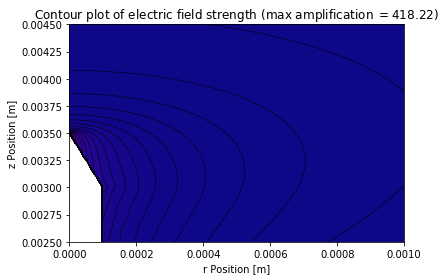

In [2]:
data_file = glob.glob(f'tip-e-fields/{subfolder}/*.txt')[0]

r, z, E_r, E_z = np.loadtxt(data_file, unpack=True)

num_r_steps = len(np.unique(r))
num_z_steps = len(np.unique(z))

r_min = r[0]
r_max = r[-1]

z_min = z[0]
z_max = z[-1]

r_vals = np.linspace(r_min, r_max, num_r_steps)
z_vals = np.linspace(z_min, z_max, num_z_steps)

strength_map = np.empty([num_z_steps, num_r_steps])

for i in range(num_r_steps):
    for j in range(num_z_steps):
        strength_map[j][i] = sqrt(E_r[j * num_r_steps + i]**2 + E_z[j * num_r_steps + i]**2)
        
max_strength = np.amax(strength_map)

plt.contour(r_vals, z_vals, strength_map, np.logspace(np.log10(bulk_field), np.log10(max_strength), 25), linewidths=0.5, colors='k')
plt.contourf(r_vals, z_vals, strength_map, np.logspace(np.log10(bulk_field), np.log10(max_strength), 25), cmap=plt.cm.plasma)

plt.xlabel('r Position [m]')
plt.ylabel('z Position [m]')

max_amp = max_strength / bulk_field
plt.title(f'Contour plot of electric field strength (max amplification $= {max_amp:.2f}$)')

The below cell generates the LUT used by the simulation, saving it as a header file.

In [3]:
if os.path.exists("../../src/LUTs/Tip.h"):
    os.remove("../../src/LUTs/Tip.h")

header = open("../../src/LUTs/Tip.h", "a+")

np.savetxt(header, [], comments="", header=f"#ifndef TIP_H\n#define TIP_H\n\nconst double bulk_field = {bulk_field};\nconst double rounded_tip = {rounded_tip};\n\nconst double top_z = {top_z};\nconst double bot_z = {bot_z};\n\nconst double top_radius = {top_radius};\nconst double bot_radius = {bot_radius};\n\nconst int num_r_steps = {num_r_steps};\nconst int num_z_steps = {num_z_steps};\n\nconst double r_min = {r_min};\nconst double r_max = {r_max};\n\nconst double z_min = {z_min};\nconst double z_max = {z_max};\n\nconst double r_conversion_factor = (num_r_steps - 1) / (r_max - r_min);\nconst double z_conversion_factor = (num_z_steps - 1) / (z_max - z_min);\n\nconst double E_r[] = {{")
np.savetxt(header, E_r, newline=",")
np.savetxt(header, [], comments="", header="\n};\n\nconst double E_z[] = {")
np.savetxt(header, E_z, newline=",")
np.savetxt(header, [], comments="", header="\n};\n\n#endif")

header.close()